In [1]:
import xarray as xr
import netCDF4 as nc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cmocean.cm as cm
import datetime as dt
import matplotlib.patches as mpatches
from matplotlib.colors import LogNorm
import pickle 
import os
from salishsea_tools import viz_tools, geo_tools
import arrow
import copy
import math
import matplotlib.dates as mdates



from salishsea_tools import visualisations as vis
from salishsea_tools import viz_tools

import gsw

from mpl_toolkits.basemap import Basemap

In [2]:
mycmap = copy.copy(cm.oxy)
mycmap.set_bad('darkgreen')

# BASEMAP PLOTTING CODE

In [3]:
def plot_basemap(ax, w_map, lons=None, lats=None, offset=[None, None], zorder=[0, 1, 2]):
    """
    """
    
    # Define map window
    lon_0 = (w_map[1] - w_map[0]) / 2 + w_map[0]
    lat_0 = (w_map[3] - w_map[2]) / 2 + w_map[2]

    # Make projection
    m = Basemap(projection='lcc', resolution='h',
                lon_0=lon_0, lat_0=lat_0,
                llcrnrlon=w_map[0], urcrnrlon=w_map[1],
                llcrnrlat=w_map[2], urcrnrlat=w_map[3], ax=ax)
    
    # Default lon/lat intervals
    if lons is None:
        lons = np.floor([w_map[0], w_map[1] + 1])
    if lats is None:
        lats = np.floor([w_map[2], w_map[3] + 1])
    
    # Add features and labels
    m.drawcoastlines(zorder=zorder[1])
    m.fillcontinents(color='Burlywood', zorder=zorder[0])
    m.drawmeridians(np.arange(*lons), labels=[0, 0, 1, 0], color='dimgray', yoffset=offset[1], zorder=zorder[2])
    m.drawparallels(np.arange(*lats), labels=[0, 1, 0, 0], color='dimgray', xoffset=offset[0], zorder=zorder[2])
    
    return m

def plot_thalweg(ax, T_lon, T_lat):
    lines = np.loadtxt('/home/sallen/MEOPAR/Tools/bathymetry/thalweg_working.txt', delimiter=" ", unpack=False)
    #lines = np.loadtxt('/ocean/atall/MOAD/analysis-abdoul/notebooks/bathy/SaanichInlet_VictoriaSill_thalweg.txt', delimiter=" ", unpack=False)
    #lines = np.loadtxt('/ocean/atall/MOAD/analysis-abdoul/notebooks/bathy/Hood_Canal_thalweg.txt', delimiter=" ", unpack=False)

    lines = lines.astype(int)

    thalweg_lon = T_lon[lines[:,0],lines[:,1]]
    thalweg_lat = T_lat[lines[:,0],lines[:,1]]
    ax.plot(thalweg_lon, thalweg_lat, 'r')

# LOAD GRID

In [4]:
meshmask = nc.Dataset('/ocean/atall/MOAD/analysis-abdoul/notebooks/bathy/mesh_mask_202310b.nc')
bathy = nc.Dataset('/ocean/atall/MOAD/analysis-abdoul/notebooks/bathy/bathymetry_202310b.nc')
grid = xr.open_dataset('/ocean/atall/MOAD/analysis-abdoul/notebooks/bathy/bathymetry_202310b.nc', mask_and_scale=False)

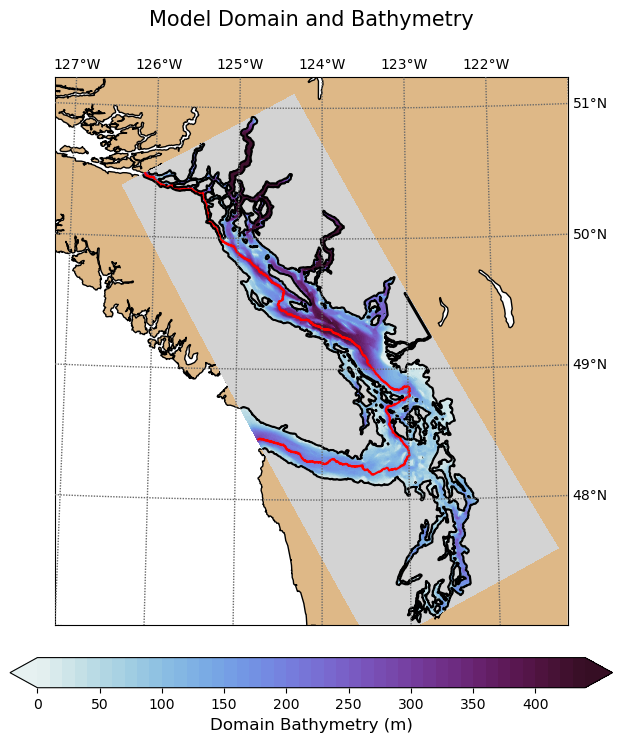

In [5]:
#set plot parameters
#scaling factor 
fact = 1
fs = 12
dicmin_twg = 1900
dicmax_twg = 2300
dicmin_surf = 0
dicmax_surf = 450
dicstep = 10

fig = plt.figure(figsize=(6.5*fact, 7.5*fact))

#domain plot - BR run summer average
ax1 = plt.subplot2grid((1,1), (0,0), colspan=1, rowspan=1) 

w_map = [-127, -121, 47, 51.2]
m = plot_basemap(ax1, w_map, zorder=[0, 1, 7]) #offset=[-30000, -15000]
x, y = m(grid['nav_lon'].values, grid['nav_lat'].values)  
#define data to plot as the surface level of the summer dataset
tdat_p = grid['Bathymetry'][:,:]
mesh = ax1.contourf(x, y, tdat_p, levels=np.arange(dicmin_surf, dicmax_surf, dicstep), \
                 cmap=cm.dense, extend = 'both') # extend='both', zorder=.2)

ax1.contourf(x, y, grid['Bathymetry'], [-0.01, 0.01], colors='lightgray', zorder=3)
ax1.contour( x, y, grid['Bathymetry'], [0], colors='Black', zorder=4)
plot_thalweg(ax1, x, y)
ax1.set_title('Model Domain and Bathymetry',fontsize = fs+3, y=1.08)

cbar = fig.colorbar(mesh, ax=ax1, orientation = 'horizontal',fraction=0.1, pad=0.05)
cbar.set_label(label='Domain Bathymetry (m)', size=fs)
#ax1.text(0.03, 0.03, 'a)', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='bottom')

plt.tight_layout()
#fig.savefig('SF_modeldomain.png',dpi = 300)

In [6]:
thalweg_SI = '/ocean/atall/MOAD/analysis-abdoul/notebooks/bathy/SaanichInlet_VictoriaSill_thalweg.txt'
thalweg_HC = '/ocean/atall/MOAD/analysis-abdoul/notebooks/bathy/Hood_Canal_thalweg.txt'
thalweg_SoG = '/home/sallen/MEOPAR/Tools/bathymetry/thalweg_working.txt'

mesh = nc.Dataset('/ocean/atall/MOAD/grid/mesh_mask202108.nc')
bathy = nc.Dataset('/ocean/atall/MOAD/grid/bathymetry_202108.nc')

meshb = nc.Dataset('/ocean/atall/MOAD/analysis-abdoul/notebooks/bathy/mesh_mask_202310b.nc')
bathyb = nc.Dataset('/ocean/atall/MOAD/analysis-abdoul/notebooks/bathy/bathymetry_202310b.nc')

depthb = meshb.variables['gdept_0'][:]
thalweg_pts0 = np.loadtxt(thalweg_SoG, delimiter=' ', dtype=int)
thalweg_pts = np.loadtxt(thalweg_SI, delimiter=' ', dtype=int)
thalweg_ptsHC = np.loadtxt(thalweg_HC, delimiter=' ', dtype=int)

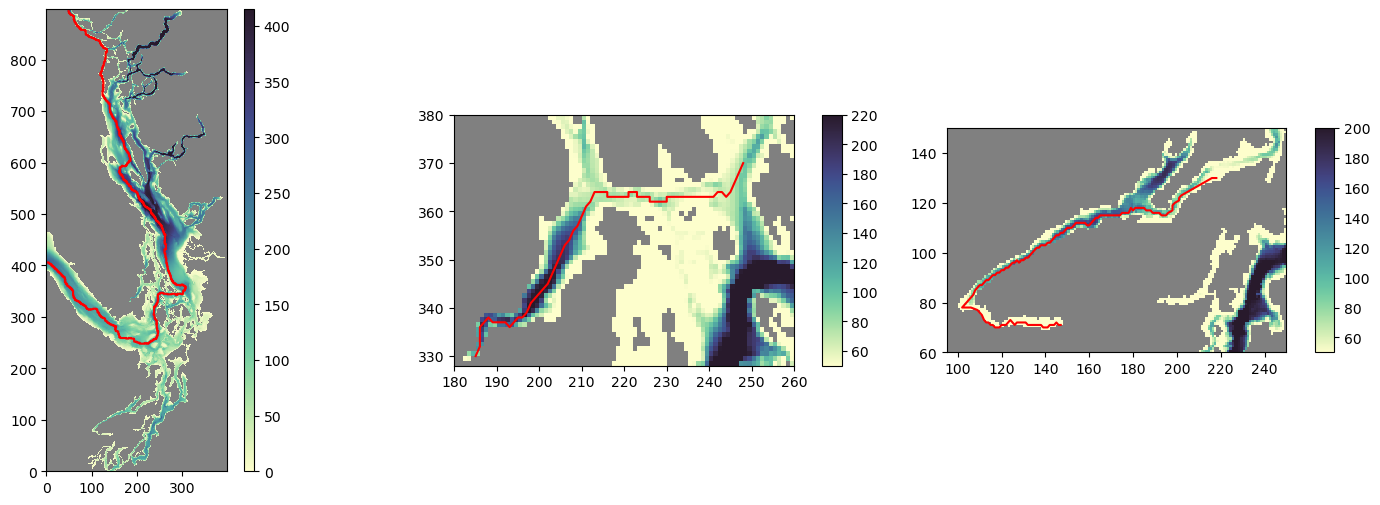

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig, ax = plt.subplots(1, 3, figsize=(18, 6))
mycmap = cm.deep
mycmap.set_bad('grey')
im = ax[0].pcolormesh(bathy.variables['Bathymetry'][:], cmap=mycmap, vmin=0, vmax=415)
ax[0].plot(thalweg_pts0[:,1],thalweg_pts0[:,0],color='r')
im2 = ax[1].pcolormesh(bathy.variables['Bathymetry'][:], cmap=mycmap, vmin=50, vmax=220)
ax[1].plot(thalweg_pts[:,1],thalweg_pts[:,0],color='r')
im3 = ax[2].pcolormesh(bathy.variables['Bathymetry'][:], cmap=mycmap, vmin=50, vmax=200)
ax[2].plot(thalweg_ptsHC[:,1],thalweg_ptsHC[:,0],color='r')
viz_tools.set_aspect(ax[0]);
viz_tools.set_aspect(ax[1]);
viz_tools.set_aspect(ax[2]);
#ax[0].set_xlim([180, 260])
#ax[0].set_ylim([328, 380])
ax[1].set_xlim([180, 260])
ax[1].set_ylim([328, 380])
ax[2].set_xlim([95, 250])
ax[2].set_ylim([60, 150])
divider = make_axes_locatable(ax[0])
divider2 = make_axes_locatable(ax[1])
divider3 = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
cax3 = divider3.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
fig.colorbar(im2, cax=cax2, orientation='vertical')
fig.colorbar(im3, cax=cax3, orientation='vertical')

In [8]:
# SalishSeaCast zz_w_sink_D_PON=1.0e-4, zz_alpha_b_D=0, Z2eff=0
df_chemTlr0 = xr.open_mfdataset('/ocean/atall/MOAD/Model/runs/salishseacast/long_run/SalishSea_1d_chemo2_2018*')
df_biolTlr0 = xr.open_mfdataset('/ocean/atall/MOAD/Model/runs/salishseacast/long_run/SalishSea_1d_PON_2018*')
# SalishSea_oxy test zz_w_sink_D_PON=1.0e-3, zz_alpha_b_D=0.5, Z2eff=0.3, zz_alpha_b_N = 0.30, zz_alpha_b_rem = 0.10
df_chemTlr1 = xr.open_mfdataset('/ocean/atall/MOAD/Model/runs/salishsea_oxy/long_run/run_first_Bremin10/SalishSea_1d_chemo2_2018*')
df_biolTlr1 = xr.open_mfdataset('/ocean/atall/MOAD/Model/runs/salishsea_oxy/long_run/run_first_Bremin10/SalishSea_1d_PON_2018*')
# SalishSea_oxy test zz_w_sink_D_PON=1.0e-3, zz_alpha_b_D=0.5, Z2eff=0.3, zz_alpha_b_N = 0.30, zz_alpha_b_rem = 0.60
df_chemTlr2 = xr.open_mfdataset('/ocean/atall/MOAD/Model/runs/salishsea_oxy/long_run/SalishSea_1d_chemo2_2018*')
df_biolTlr2 = xr.open_mfdataset('/ocean/atall/MOAD/Model/runs/salishsea_oxy/long_run/SalishSea_1d_PON_2018*')


# Strait of Georgia

KeyboardInterrupt: 

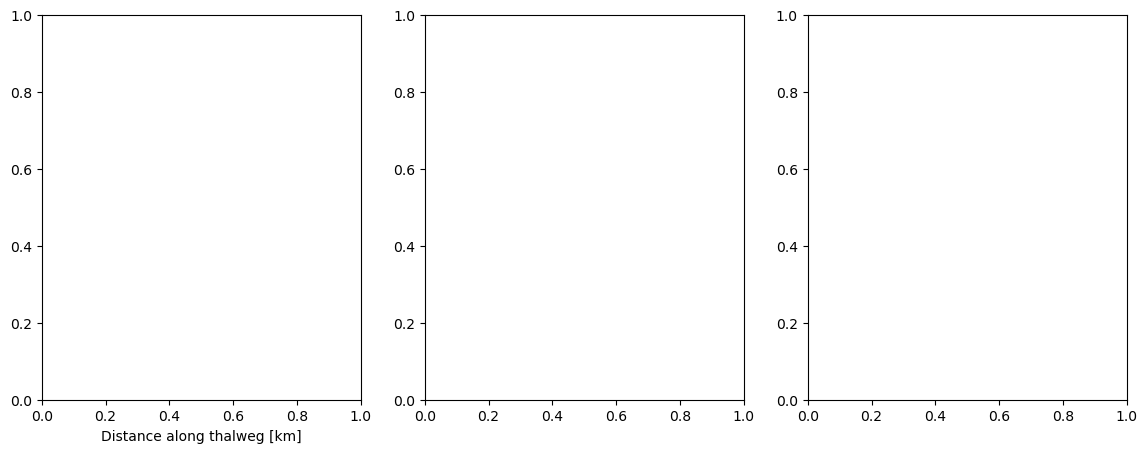

In [9]:
fig, ax = plt.subplots(1, 3, figsize = (14, 5))
modvar1='particulate_organic_nitrogen'
modvar2='dissolved_oxygen'
level_pon = np.linspace(0,10,20)
old0=vis.contour_thalweg(ax[0,0],df_biolTlr0.variables[modvar1].mean(axis=0),bathy,mesh,clevels=level,cmap=cm.amp,thalweg_file=thalweg_SoG,cbar_args={'label':modvar})
new1=vis.contour_thalweg(ax[0,1],df_biolTlr1.variables[modvar1].mean(axis=0),bathy,mesh,clevels=level,cmap=cm.amp,thalweg_file=thalweg_SoG,cbar_args={'label':modvar})
new2=vis.contour_thalweg(ax[0,2],df_biolTlr2.variables[modvar1].mean(axis=0),bathy,mesh,clevels=level,cmap=cm.amp,thalweg_file=thalweg_SoG,cbar_args={'label':modvar})

ax[0,0].set_ylim([450, 0])
ax[0,1].set_ylim([450, 0])
ax[0,2].set_ylim([450, 0])
ax[1,0].set_ylim([450, 0])
ax[1,1].set_ylim([450, 0])
ax[1,2].set_ylim([450, 0])
ax[0,0].set_title('PON-202111')
ax[0,1].set_title('PON-Bremin=0.10')
ax[0,2].set_title('PON-Bremin=0.60')
ax[1,0].set_title('DO-202111')
ax[1,1].set_title('DO-Bremin=0.10')
ax[1,2].set_title('DO-Bremin=0.60')
#fig.suptitle('PON - 2018');


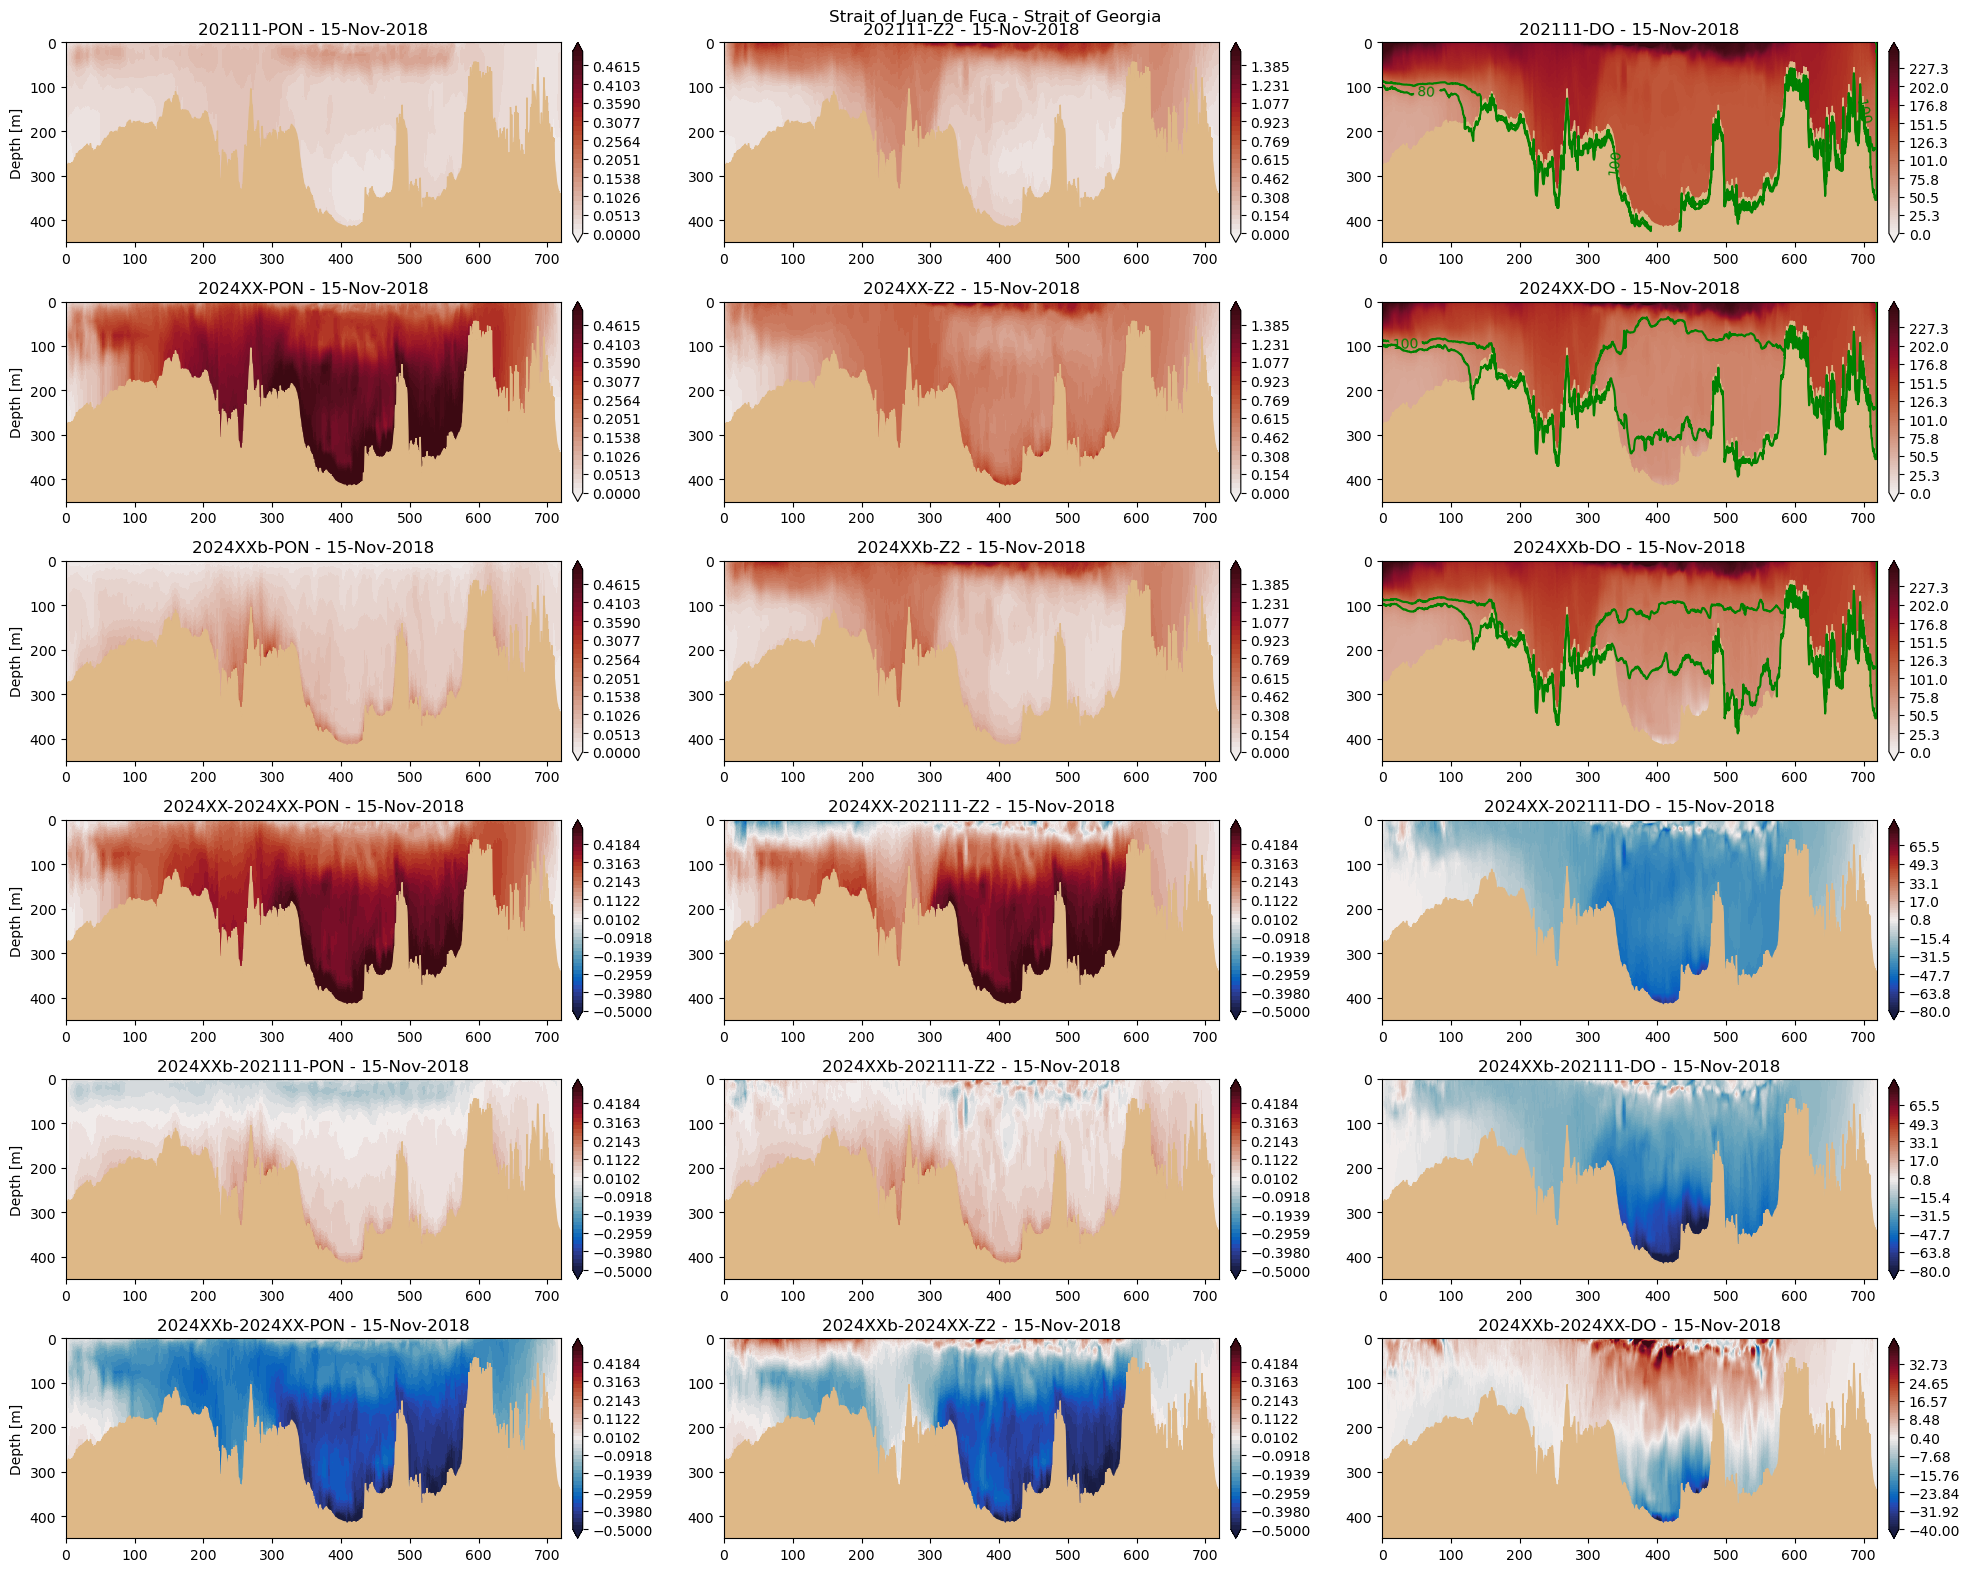

In [37]:
fig, axs = plt.subplots(6, 3, figsize=(20, 16))
lp, cppon, cpmes, cpoxy = 0, 0, 1, 2
Month = list(['14-Nov-2018','15-Nov-2018'])
for month in range(76, 76+1):
    dep_thal, distance, pon_thal = vis.load_thalweg(
                depthb[0, ...], np.array(df_chemTlr0.dissolved_oxygen[month-1]), bathyb['nav_lon'][:], bathyb['nav_lat'][:],
                thalweg_pts0)
    dep_thal2, distance2, pon_thal2 = vis.load_thalweg(
                depthb[0, ...], np.array(df_chemTlr1.dissolved_oxygen[month-1]), bathyb['nav_lon'][:], bathyb['nav_lat'][:],
                thalweg_pts0)
    dep_thal2b, distance2b, pon_thal2b = vis.load_thalweg(
                depthb[0, ...], np.array(df_chemTlr2.dissolved_oxygen[month-1]), bathyb['nav_lon'][:], bathyb['nav_lat'][:],
                thalweg_pts0)
    dep_thal, distance, mes_thal = vis.load_thalweg(
                depthb[0, ...], np.array(df_biolold.mesozooplankton[month-1]), bathyb['nav_lon'][:], bathyb['nav_lat'][:],
                thalweg_pts0)
    dep_thal2, distance2, mes_thal2 = vis.load_thalweg(
                depthb[0, ...], np.array(df_biol.mesozooplankton[month-1]), bathyb['nav_lon'][:], bathyb['nav_lat'][:],
                thalweg_pts0)
    dep_thal2b, distance2b, mes_thal2b = vis.load_thalweg(
                depthb[0, ...], np.array(df_biolb.mesozooplankton[month-1]), bathyb['nav_lon'][:], bathyb['nav_lat'][:],
                thalweg_pts0)
    dep_thal, distance, oxy_thal = vis.load_thalweg(
                depthb[0, ...], np.array(df_chemold.dissolved_oxygen[month-1]), bathyb['nav_lon'][:], bathyb['nav_lat'][:],
                thalweg_pts0)
    dep_thal2, distance2, oxy_thal2 = vis.load_thalweg(
                depthb[0, ...], np.array(df_chem.dissolved_oxygen[month-1]), bathyb['nav_lon'][:], bathyb['nav_lat'][:],
                thalweg_pts0)
    dep_thal2b, distance2b, oxy_thal2b = vis.load_thalweg(
                depthb[0, ...], np.array(df_chemb.dissolved_oxygen[month-1]), bathyb['nav_lon'][:], bathyb['nav_lat'][:],
                thalweg_pts0)
    pon_plot = vis._fill_in_bathy(pon_thal, meshb, thalweg_pts0)
    mes_plot = vis._fill_in_bathy(mes_thal, meshb, thalweg_pts0)
    oxy_plot = vis._fill_in_bathy(oxy_thal, meshb, thalweg_pts0)
    pon_plot2 = vis._fill_in_bathy(pon_thal2, meshb, thalweg_pts0)
    mes_plot2 = vis._fill_in_bathy(mes_thal2, meshb, thalweg_pts0)
    oxy_plot2 = vis._fill_in_bathy(oxy_thal2, meshb, thalweg_pts0)
    pon_plot2b = vis._fill_in_bathy(pon_thal2b, meshb, thalweg_pts0)
    mes_plot2b = vis._fill_in_bathy(mes_thal2b, meshb, thalweg_pts0)
    oxy_plot2b = vis._fill_in_bathy(oxy_thal2b, meshb, thalweg_pts0)
    pon_diff = vis._fill_in_bathy(pon_thal2b-pon_thal2, meshb, thalweg_pts0)
    mes_diff = vis._fill_in_bathy(mes_thal2b-mes_thal2, meshb, thalweg_pts0)
    oxy_diff = vis._fill_in_bathy(oxy_thal2b-oxy_thal2, meshb, thalweg_pts0)
    pon_diff2 = vis._fill_in_bathy(pon_thal2-pon_thal, meshb, thalweg_pts0)
    mes_diff2 = vis._fill_in_bathy(mes_thal2-mes_thal, meshb, thalweg_pts0)
    oxy_diff2 = vis._fill_in_bathy(oxy_thal2-oxy_thal, meshb, thalweg_pts0)
    pon_diff2b = vis._fill_in_bathy(pon_thal2b-pon_thal, meshb, thalweg_pts0)
    mes_diff2b = vis._fill_in_bathy(mes_thal2b-mes_thal, meshb, thalweg_pts0)
    oxy_diff2b = vis._fill_in_bathy(oxy_thal2b-oxy_thal, meshb, thalweg_pts0)
    colours_pon = axs[lp,cppon].contourf(distance, dep_thal, pon_plot, np.linspace(0, 0.5, 40), 
                                     cmap=cm.amp, extend='both')
    colours_mes = axs[lp,cpmes].contourf(distance, dep_thal, mes_plot, np.linspace(0, 1.5, 40), 
                                     cmap=cm.amp, extend='both')
    colours_oxy = axs[lp,cpoxy].contourf(distance, dep_thal, oxy_plot, np.linspace(0, 250, 100),                                     
                                    cmap=cm.amp, extend='both')
    colours_oxyc = axs[lp,cpoxy].contour(distance, dep_thal,  oxy_plot, np.arange(80, 120, 20),
                                     colors='g', extend='both')
    
    colours_pon2 = axs[lp+1,cppon].contourf(distance2, dep_thal2, pon_plot2, np.linspace(0, 0.5, 40), 
                                     cmap=cm.amp, extend='both')
    colours_mes2 = axs[lp+1,cpmes].contourf(distance2, dep_thal2, mes_plot2, np.linspace(0, 1.5, 40), 
                                     cmap=cm.amp, extend='both')
    colours_oxy2 = axs[lp+1,cpoxy].contourf(distance2, dep_thal2, oxy_plot2, np.linspace(0, 250, 100),                                     
                                    cmap=cm.amp, extend='both')
    colours_oxyc2 = axs[lp+1,cpoxy].contour(distance2, dep_thal2,  oxy_plot2, np.arange(80, 120, 20),
                                     colors='g', extend='both')
    colours_pon2b = axs[lp+2,cppon].contourf(distance2b, dep_thal2b, pon_plot2b, np.linspace(0, 0.5, 40), 
                                     cmap=cm.amp, extend='both')
    colours_mes2b = axs[lp+2,cpmes].contourf(distance2b, dep_thal2b, mes_plot2b, np.linspace(0, 1.5, 40), 
                                     cmap=cm.amp, extend='both')
    colours_oxy2b = axs[lp+2,cpoxy].contourf(distance2b, dep_thal2b, oxy_plot2b, np.linspace(0, 250, 100), 
                                             cmap=cm.amp, extend='both')
    colours_oxyc2b = axs[lp+2,cpoxy].contour(distance2b, dep_thal2b,  oxy_plot2b, np.arange(80, 120, 20),
                                     colors='g', extend='both')
    colours_pon32 = axs[lp+3,cppon].contourf(distance2, dep_thal2, pon_diff2, np.linspace(-0.5, 0.5, 50), 
                                     cmap=cm.balance, extend='both')
    colours_mes32 = axs[lp+3,cpmes].contourf(distance2, dep_thal2, mes_diff2, np.linspace(-0.5, 0.5, 50), 
                                     cmap=cm.balance, extend='both')
    colours_oxy32 = axs[lp+3,cpoxy].contourf(distance2, dep_thal2, oxy_diff2, np.linspace(-80, 80, 100),                                     
                                    cmap=cm.balance, extend='both')
    colours_pon32b = axs[lp+4,cppon].contourf(distance2, dep_thal2, pon_diff2b, np.linspace(-0.5, 0.5, 50), 
                                     cmap=cm.balance, extend='both')
    colours_mes32b = axs[lp+4,cpmes].contourf(distance2, dep_thal2, mes_diff2b, np.linspace(-0.5, 0.5, 50), 
                                     cmap=cm.balance, extend='both')
    colours_oxy32b = axs[lp+4,cpoxy].contourf(distance2b, dep_thal2b, oxy_diff2b, np.linspace(-80, 80, 100),                                     
                                    cmap=cm.balance, extend='both')
    colours_pon3 = axs[lp+5,cppon].contourf(distance2, dep_thal2, pon_diff, np.linspace(-0.5, 0.5, 50), 
                                     cmap=cm.balance, extend='both')
    colours_mes3 = axs[lp+5,cpmes].contourf(distance2, dep_thal2, mes_diff, np.linspace(-0.5, 0.5, 50), 
                                     cmap=cm.balance, extend='both')
    colours_oxy3 = axs[lp+5,cpoxy].contourf(distance2, dep_thal2, oxy_diff, np.linspace(-40, 40, 100),                                     
                                    cmap=cm.balance, extend='both')
    axs[lp,cpoxy].clabel(colours_oxyc, inline=True, fontsize=10)
    axs[lp+1,cpoxy].clabel(colours_oxyc2, inline=True, fontsize=10)
    vis._add_bathy_patch(
    distance, bathyb['Bathymetry'][:], thalweg_pts0, axs[lp,cppon], color='burlywood')
    vis._add_bathy_patch(
    distance, bathyb['Bathymetry'][:], thalweg_pts0, axs[lp,cpmes], color='burlywood')
    vis._add_bathy_patch(
    distance, bathyb['Bathymetry'][:], thalweg_pts0, axs[lp,cpoxy], color='burlywood')
    vis._add_bathy_patch(
    distance2, bathyb['Bathymetry'][:], thalweg_pts0, axs[lp+1,cppon], color='burlywood')
    vis._add_bathy_patch(
    distance2, bathyb['Bathymetry'][:], thalweg_pts0, axs[lp+1,cpmes], color='burlywood')
    vis._add_bathy_patch(
    distance2, bathyb['Bathymetry'][:], thalweg_pts0, axs[lp+1,cpoxy], color='burlywood')
    vis._add_bathy_patch(
    distance2b, bathyb['Bathymetry'][:], thalweg_pts0, axs[lp+2,cppon], color='burlywood')
    vis._add_bathy_patch(
    distance2b, bathyb['Bathymetry'][:], thalweg_pts0, axs[lp+2,cpmes], color='burlywood')
    vis._add_bathy_patch(
    distance2b, bathyb['Bathymetry'][:], thalweg_pts0, axs[lp+2,cpoxy], color='burlywood')
    vis._add_bathy_patch(
    distance2, bathyb['Bathymetry'][:], thalweg_pts0, axs[lp+3,cppon], color='burlywood')
    vis._add_bathy_patch(
    distance2, bathyb['Bathymetry'][:], thalweg_pts0, axs[lp+3,cpmes], color='burlywood')
    vis._add_bathy_patch(
    distance2, bathyb['Bathymetry'][:], thalweg_pts0, axs[lp+3,cpoxy], color='burlywood')
    vis._add_bathy_patch(
    distance2, bathyb['Bathymetry'][:], thalweg_pts0, axs[lp+4,cppon], color='burlywood')
    vis._add_bathy_patch(
    distance2, bathyb['Bathymetry'][:], thalweg_pts0, axs[lp+4,cpmes], color='burlywood')
    vis._add_bathy_patch(
    distance2, bathyb['Bathymetry'][:], thalweg_pts0, axs[lp+4,cpoxy], color='burlywood')
    vis._add_bathy_patch(
    distance2, bathyb['Bathymetry'][:], thalweg_pts0, axs[lp+5,cppon], color='burlywood')
    vis._add_bathy_patch(
    distance2, bathyb['Bathymetry'][:], thalweg_pts0, axs[lp+5,cpmes], color='burlywood')
    vis._add_bathy_patch(
    distance2, bathyb['Bathymetry'][:], thalweg_pts0, axs[lp+5,cpoxy], color='burlywood')
    axs[lp,cppon].invert_yaxis()
    axs[lp,cpmes].invert_yaxis()
    axs[lp,cpoxy].invert_yaxis()
    axs[lp+1,cppon].invert_yaxis()
    axs[lp+1,cpmes].invert_yaxis()
    axs[lp+1,cpoxy].invert_yaxis()
    axs[lp,cppon].set_ylim(450, 0)
    axs[lp,cpmes].set_ylim(450, 0)
    axs[lp,cpoxy].set_ylim(450, 0)
    axs[lp+1,cppon].set_ylim(450, 0)
    axs[lp+1,cpmes].set_ylim(450, 0)
    axs[lp+1,cpoxy].set_ylim(450, 0)
    axs[lp+2,cppon].set_ylim(450, 0)
    axs[lp+2,cpmes].set_ylim(450, 0)
    axs[lp+2,cpoxy].set_ylim(450, 0)
    axs[lp+3,cppon].set_ylim(450, 0)
    axs[lp+3,cpmes].set_ylim(450, 0)
    axs[lp+3,cpoxy].set_ylim(450, 0)
    axs[lp+4,cppon].set_ylim(450, 0)
    axs[lp+4,cpmes].set_ylim(450, 0)
    axs[lp+4,cpoxy].set_ylim(450, 0)
    axs[lp+5,cppon].set_ylim(450, 0)
    axs[lp+5,cpmes].set_ylim(450, 0)
    axs[lp+5,cpoxy].set_ylim(450, 0)
    axs[lp,cppon].set_ylabel('Depth [m]');
    axs[lp+1,cppon].set_ylabel('Depth [m]');
    axs[lp+2,cppon].set_ylabel('Depth [m]');
    axs[lp+3,cppon].set_ylabel('Depth [m]');
    axs[lp+4,cppon].set_ylabel('Depth [m]');
    axs[lp+5,cppon].set_ylabel('Depth [m]');
    axs[lp,cppon].set_title(f'202111-PON - {Month[month-75]}')
    axs[lp,cpmes].set_title(f'202111-Z2 - {Month[month-75]}')
    axs[lp,cpoxy].set_title(f'202111-DO - {Month[month-75]}')
    axs[lp+1,cppon].set_title(f'2024XX-PON - {Month[month-75]}')
    axs[lp+1,cpmes].set_title(f'2024XX-Z2 - {Month[month-75]}')
    axs[lp+1,cpoxy].set_title(f'2024XX-DO - {Month[month-75]}')
    axs[lp+2,cppon].set_title(f'2024XXb-PON - {Month[month-75]}')
    axs[lp+2,cpmes].set_title(f'2024XXb-Z2 - {Month[month-75]}')
    axs[lp+2,cpoxy].set_title(f'2024XXb-DO - {Month[month-75]}')
    axs[lp+3,cppon].set_title(f'2024XX-2024XX-PON - {Month[month-75]}')
    axs[lp+3,cpmes].set_title(f'2024XX-202111-Z2 - {Month[month-75]}')
    axs[lp+3,cpoxy].set_title(f'2024XX-202111-DO - {Month[month-75]}')
    axs[lp+4,cppon].set_title(f'2024XXb-202111-PON - {Month[month-75]}')
    axs[lp+4,cpmes].set_title(f'2024XXb-202111-Z2 - {Month[month-75]}')
    axs[lp+4,cpoxy].set_title(f'2024XXb-202111-DO - {Month[month-75]}')
    axs[lp+5,cppon].set_title(f'2024XXb-2024XX-PON - {Month[month-75]}')
    axs[lp+5,cpmes].set_title(f'2024XXb-2024XX-Z2 - {Month[month-75]}')
    axs[lp+5,cpoxy].set_title(f'2024XXb-2024XX-DO - {Month[month-75]}')
    cbar = fig.colorbar(colours_pon, ax=axs[lp,cppon], pad=0.02)
    cbar = fig.colorbar(colours_mes, ax=axs[lp,cpmes], pad=0.02)
    cbar = fig.colorbar(colours_oxy, ax=axs[lp,cpoxy], pad=0.02)
    cbar = fig.colorbar(colours_pon2, ax=axs[lp+1,cppon], pad=0.02)
    cbar = fig.colorbar(colours_mes2, ax=axs[lp+1,cpmes], pad=0.02)
    cbar = fig.colorbar(colours_oxy2, ax=axs[lp+1,cpoxy], pad=0.02)
    cbar = fig.colorbar(colours_pon2b, ax=axs[lp+2,cppon], pad=0.02)
    cbar = fig.colorbar(colours_mes2b, ax=axs[lp+2,cpmes], pad=0.02)
    cbar = fig.colorbar(colours_oxy2b, ax=axs[lp+2,cpoxy], pad=0.02)
    cbar = fig.colorbar(colours_pon32, ax=axs[lp+3,cppon], pad=0.02)
    cbar = fig.colorbar(colours_mes32, ax=axs[lp+3,cpmes], pad=0.02)
    cbar = fig.colorbar(colours_oxy32, ax=axs[lp+3,cpoxy], pad=0.02)
    cbar = fig.colorbar(colours_pon32b, ax=axs[lp+4,cppon], pad=0.02)
    cbar = fig.colorbar(colours_mes32b, ax=axs[lp+4,cpmes], pad=0.02)
    cbar = fig.colorbar(colours_oxy32b, ax=axs[lp+4,cpoxy], pad=0.02)
    cbar = fig.colorbar(colours_pon3, ax=axs[lp+5,cppon], pad=0.02)
    cbar = fig.colorbar(colours_mes3, ax=axs[lp+5,cpmes], pad=0.02)
    cbar = fig.colorbar(colours_oxy3, ax=axs[lp+5,cpoxy], pad=0.02)
#    lp = lp + 1;
fig.suptitle('Strait of Juan de Fuca - Strait of Georgia');
fig.tight_layout();

# Saanich Inlet

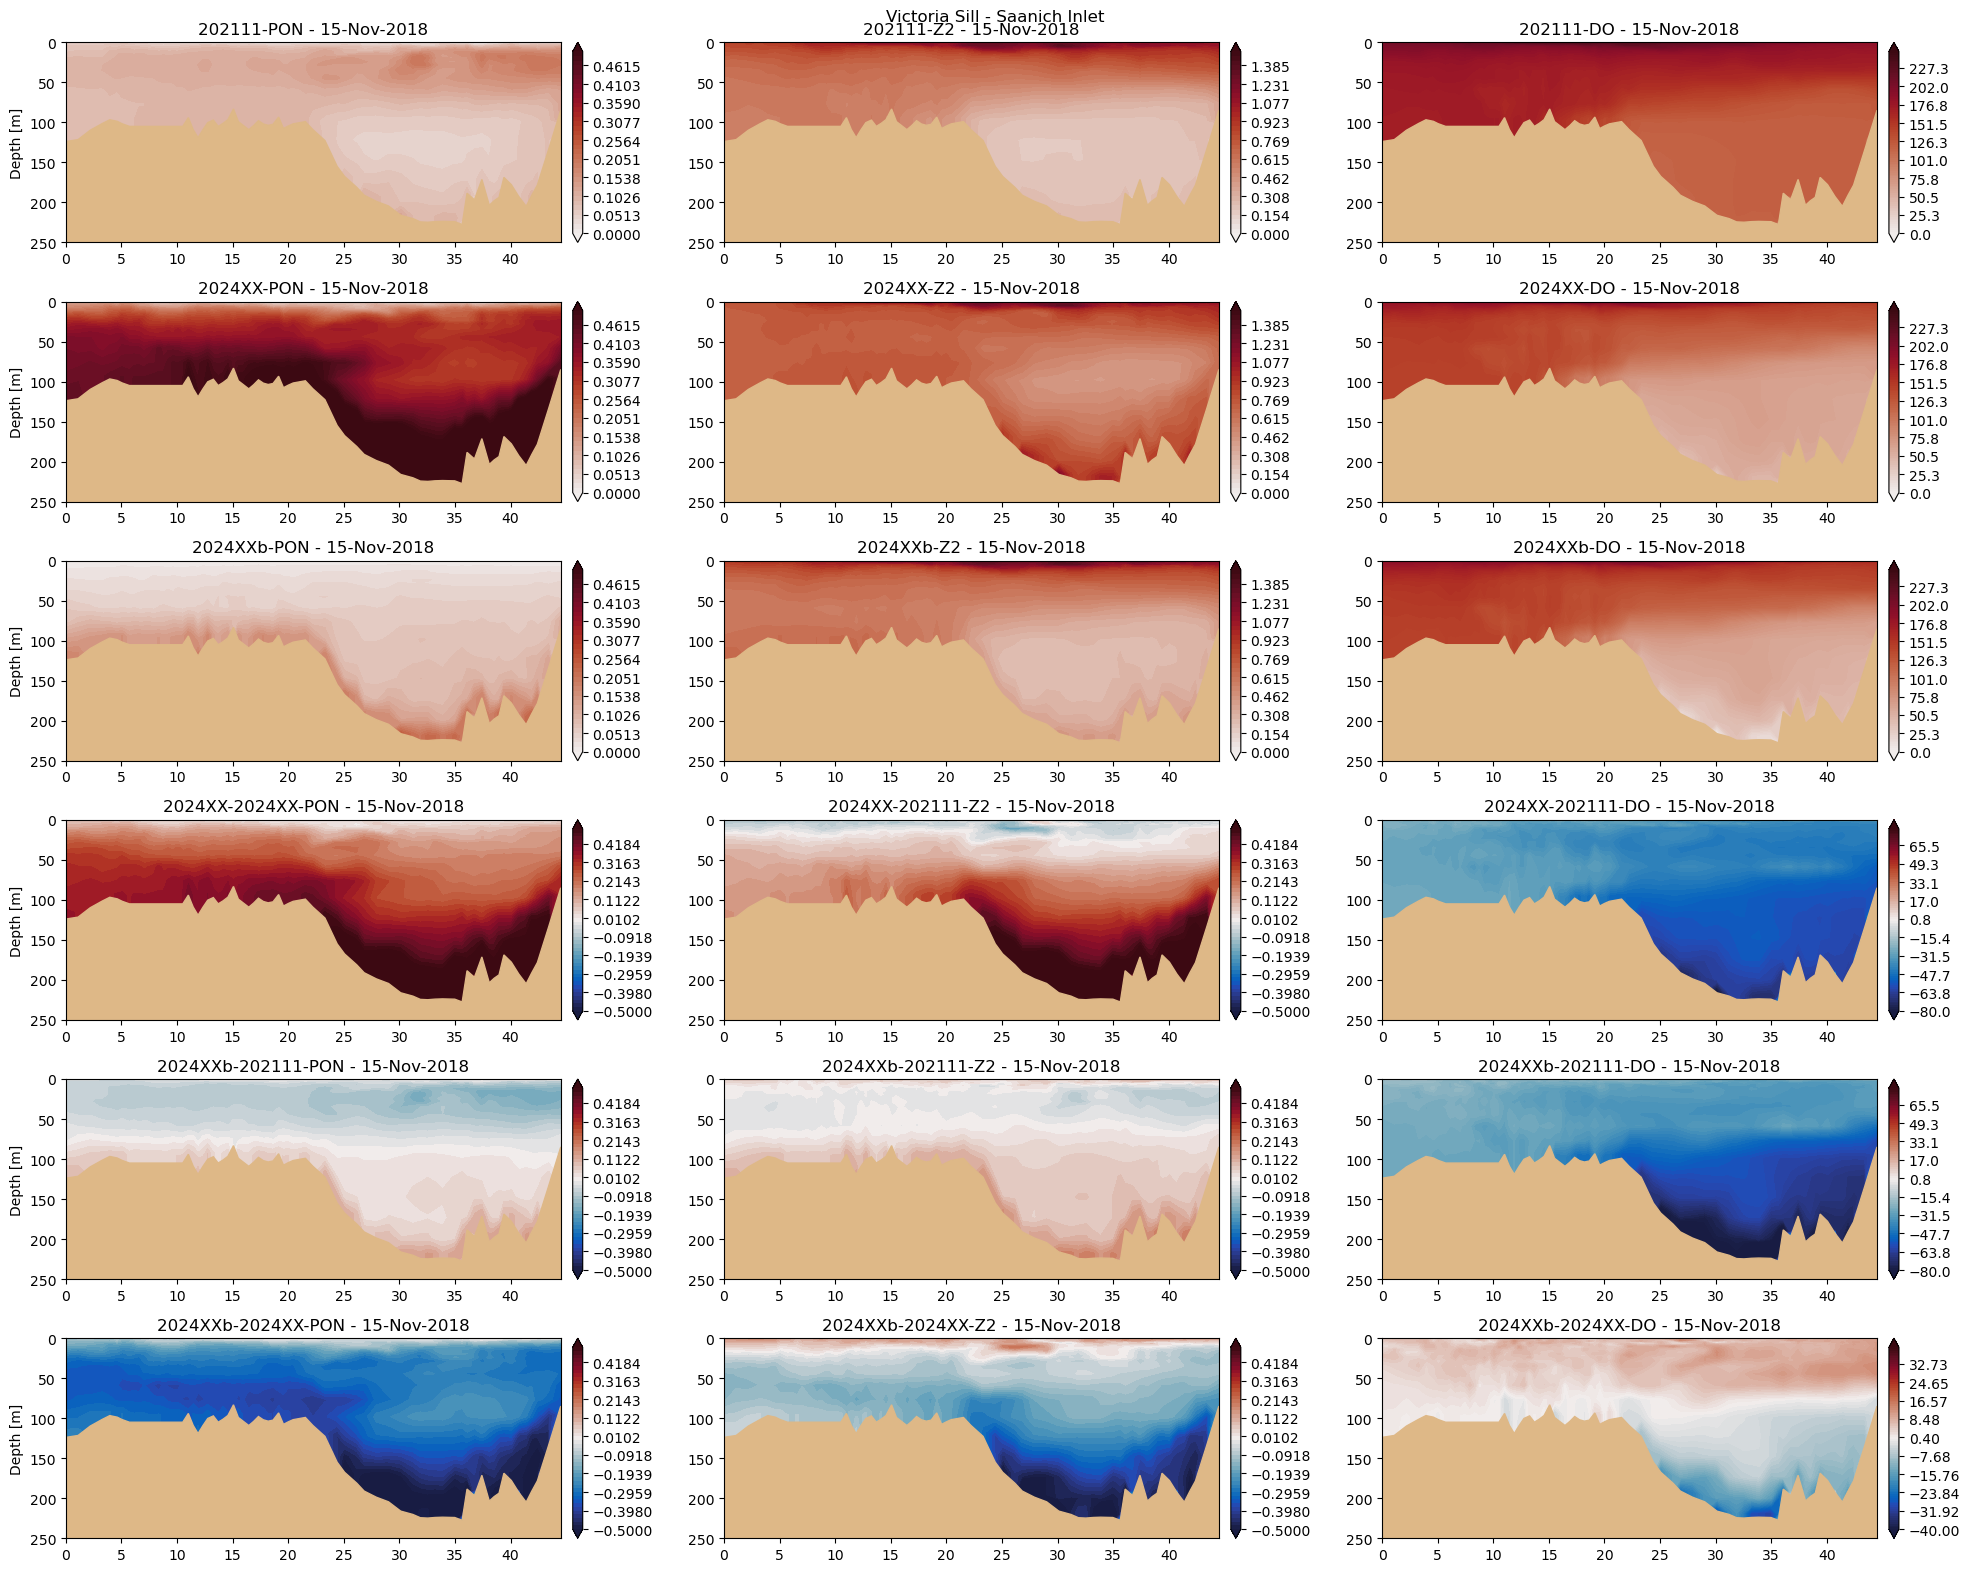

In [35]:
fig, axs = plt.subplots(6, 3, figsize=(20, 16))
lp, cppon, cpmes, cpoxy = 0, 0, 1, 2
Month = list(['14-Nov-2018','15-Nov-2018'])
for month in range(76, 76+1):
    dep_thal, distance, pon_thal = vis.load_thalweg(
                depthb[0, ...], np.array(df_biolold.particulate_organic_nitrogen[month-1]), bathyb['nav_lon'][:], bathyb['nav_lat'][:],
                thalweg_pts)
    dep_thal2, distance2, pon_thal2 = vis.load_thalweg(
                depthb[0, ...], np.array(df_biol.particulate_organic_nitrogen[month-1]), bathyb['nav_lon'][:], bathyb['nav_lat'][:],
                thalweg_pts)
    dep_thal2b, distance2b, pon_thal2b = vis.load_thalweg(
                depthb[0, ...], np.array(df_biolb.particulate_organic_nitrogen[month-1]), bathyb['nav_lon'][:], bathyb['nav_lat'][:],
                thalweg_pts)
    dep_thal, distance, mes_thal = vis.load_thalweg(
                depthb[0, ...], np.array(df_biolold.mesozooplankton[month-1]), bathyb['nav_lon'][:], bathyb['nav_lat'][:],
                thalweg_pts)
    dep_thal2, distance2, mes_thal2 = vis.load_thalweg(
                depthb[0, ...], np.array(df_biol.mesozooplankton[month-1]), bathyb['nav_lon'][:], bathyb['nav_lat'][:],
                thalweg_pts)
    dep_thal2b, distance2b, mes_thal2b = vis.load_thalweg(
                depthb[0, ...], np.array(df_biolb.mesozooplankton[month-1]), bathyb['nav_lon'][:], bathyb['nav_lat'][:],
                thalweg_pts)
    dep_thal, distance, oxy_thal = vis.load_thalweg(
                depthb[0, ...], np.array(df_chemold.dissolved_oxygen[month-1]), bathyb['nav_lon'][:], bathyb['nav_lat'][:],
                thalweg_pts)
    dep_thal2, distance2, oxy_thal2 = vis.load_thalweg(
                depthb[0, ...], np.array(df_chem.dissolved_oxygen[month-1]), bathyb['nav_lon'][:], bathyb['nav_lat'][:],
                thalweg_pts)
    dep_thal2b, distance2b, oxy_thal2b = vis.load_thalweg(
                depthb[0, ...], np.array(df_chemb.dissolved_oxygen[month-1]), bathyb['nav_lon'][:], bathyb['nav_lat'][:],
                thalweg_pts)
    pon_plot = vis._fill_in_bathy(pon_thal, meshb, thalweg_pts)
    mes_plot = vis._fill_in_bathy(mes_thal, meshb, thalweg_pts)
    oxy_plot = vis._fill_in_bathy(oxy_thal, meshb, thalweg_pts)
    pon_plot2 = vis._fill_in_bathy(pon_thal2, meshb, thalweg_pts)
    mes_plot2 = vis._fill_in_bathy(mes_thal2, meshb, thalweg_pts)
    oxy_plot2 = vis._fill_in_bathy(oxy_thal2, meshb, thalweg_pts)
    pon_plot2b = vis._fill_in_bathy(pon_thal2b, meshb, thalweg_pts)
    mes_plot2b = vis._fill_in_bathy(mes_thal2b, meshb, thalweg_pts)
    oxy_plot2b = vis._fill_in_bathy(oxy_thal2b, meshb, thalweg_pts)
    pon_diff = vis._fill_in_bathy(pon_thal2b-pon_thal2, meshb, thalweg_pts)
    mes_diff = vis._fill_in_bathy(mes_thal2b-mes_thal2, meshb, thalweg_pts)
    oxy_diff = vis._fill_in_bathy(oxy_thal2b-oxy_thal2, meshb, thalweg_pts)
    pon_diff2 = vis._fill_in_bathy(pon_thal2-pon_thal, meshb, thalweg_pts)
    mes_diff2 = vis._fill_in_bathy(mes_thal2-mes_thal, meshb, thalweg_pts)
    oxy_diff2 = vis._fill_in_bathy(oxy_thal2-oxy_thal, meshb, thalweg_pts)
    pon_diff2b = vis._fill_in_bathy(pon_thal2b-pon_thal, meshb, thalweg_pts)
    mes_diff2b = vis._fill_in_bathy(mes_thal2b-mes_thal, meshb, thalweg_pts)
    oxy_diff2b = vis._fill_in_bathy(oxy_thal2b-oxy_thal, meshb, thalweg_pts)
    colours_pon = axs[lp,cppon].contourf(distance, dep_thal, pon_plot, np.linspace(0, 0.5, 40), 
                                     cmap=cm.amp, extend='both')
    colours_mes = axs[lp,cpmes].contourf(distance, dep_thal, mes_plot, np.linspace(0, 1.5, 40), 
                                     cmap=cm.amp, extend='both')
    colours_oxy = axs[lp,cpoxy].contourf(distance, dep_thal, oxy_plot, np.linspace(0, 250, 100),                                     
                                    cmap=cm.amp, extend='both') 
    colours_pon2 = axs[lp+1,cppon].contourf(distance2, dep_thal2, pon_plot2, np.linspace(0, 0.5, 40), 
                                     cmap=cm.amp, extend='both')
    colours_mes2 = axs[lp+1,cpmes].contourf(distance2, dep_thal2, mes_plot2, np.linspace(0, 1.5, 40), 
                                     cmap=cm.amp, extend='both')
    colours_oxy2 = axs[lp+1,cpoxy].contourf(distance2, dep_thal2, oxy_plot2, np.linspace(0, 250, 100),                                     
                                    cmap=cm.amp, extend='both')
    colours_pon2b = axs[lp+2,cppon].contourf(distance2b, dep_thal2b, pon_plot2b, np.linspace(0, 0.5, 40), 
                                     cmap=cm.amp, extend='both')
    colours_mes2b = axs[lp+2,cpmes].contourf(distance2b, dep_thal2b, mes_plot2b, np.linspace(0, 1.5, 40), 
                                     cmap=cm.amp, extend='both')
    colours_oxy2b = axs[lp+2,cpoxy].contourf(distance2b, dep_thal2b, oxy_plot2b, np.linspace(0, 250, 100), 
                                             cmap=cm.amp, extend='both')
    colours_pon32 = axs[lp+3,cppon].contourf(distance2, dep_thal2, pon_diff2, np.linspace(-0.5, 0.5, 50), 
                                     cmap=cm.balance, extend='both')
    colours_mes32 = axs[lp+3,cpmes].contourf(distance2, dep_thal2, mes_diff2, np.linspace(-0.5, 0.5, 50), 
                                     cmap=cm.balance, extend='both')
    colours_oxy32 = axs[lp+3,cpoxy].contourf(distance2, dep_thal2, oxy_diff2, np.linspace(-80, 80, 100),                                     
                                    cmap=cm.balance, extend='both')
    colours_pon32b = axs[lp+4,cppon].contourf(distance2, dep_thal2, pon_diff2b, np.linspace(-0.5, 0.5, 50), 
                                     cmap=cm.balance, extend='both')
    colours_mes32b = axs[lp+4,cpmes].contourf(distance2, dep_thal2, mes_diff2b, np.linspace(-0.5, 0.5, 50), 
                                     cmap=cm.balance, extend='both')
    colours_oxy32b = axs[lp+4,cpoxy].contourf(distance2b, dep_thal2b, oxy_diff2b, np.linspace(-80, 80, 100),                                     
                                    cmap=cm.balance, extend='both')
    colours_pon3 = axs[lp+5,cppon].contourf(distance2, dep_thal2, pon_diff, np.linspace(-0.5, 0.5, 50), 
                                     cmap=cm.balance, extend='both')
    colours_mes3 = axs[lp+5,cpmes].contourf(distance2, dep_thal2, mes_diff, np.linspace(-0.5, 0.5, 50), 
                                     cmap=cm.balance, extend='both')
    colours_oxy3 = axs[lp+5,cpoxy].contourf(distance2, dep_thal2, oxy_diff, np.linspace(-40, 40, 100),                                     
                                    cmap=cm.balance, extend='both')
    vis._add_bathy_patch(
    distance, bathyb['Bathymetry'][:], thalweg_pts, axs[lp,cppon], color='burlywood')
    vis._add_bathy_patch(
    distance, bathyb['Bathymetry'][:], thalweg_pts, axs[lp,cpmes], color='burlywood')
    vis._add_bathy_patch(
    distance, bathyb['Bathymetry'][:], thalweg_pts, axs[lp,cpoxy], color='burlywood')
    vis._add_bathy_patch(
    distance2, bathyb['Bathymetry'][:], thalweg_pts, axs[lp+1,cppon], color='burlywood')
    vis._add_bathy_patch(
    distance2, bathyb['Bathymetry'][:], thalweg_pts, axs[lp+1,cpmes], color='burlywood')
    vis._add_bathy_patch(
    distance2, bathyb['Bathymetry'][:], thalweg_pts, axs[lp+1,cpoxy], color='burlywood')
    vis._add_bathy_patch(
    distance2b, bathyb['Bathymetry'][:], thalweg_pts, axs[lp+2,cppon], color='burlywood')
    vis._add_bathy_patch(
    distance2b, bathyb['Bathymetry'][:], thalweg_pts, axs[lp+2,cpmes], color='burlywood')
    vis._add_bathy_patch(
    distance2b, bathyb['Bathymetry'][:], thalweg_pts, axs[lp+2,cpoxy], color='burlywood')
    vis._add_bathy_patch(
    distance2, bathyb['Bathymetry'][:], thalweg_pts, axs[lp+3,cppon], color='burlywood')
    vis._add_bathy_patch(
    distance2, bathyb['Bathymetry'][:], thalweg_pts, axs[lp+3,cpmes], color='burlywood')
    vis._add_bathy_patch(
    distance2, bathyb['Bathymetry'][:], thalweg_pts, axs[lp+3,cpoxy], color='burlywood')
    vis._add_bathy_patch(
    distance2, bathyb['Bathymetry'][:], thalweg_pts, axs[lp+4,cppon], color='burlywood')
    vis._add_bathy_patch(
    distance2, bathyb['Bathymetry'][:], thalweg_pts, axs[lp+4,cpmes], color='burlywood')
    vis._add_bathy_patch(
    distance2, bathyb['Bathymetry'][:], thalweg_pts, axs[lp+4,cpoxy], color='burlywood')
    vis._add_bathy_patch(
    distance2, bathyb['Bathymetry'][:], thalweg_pts, axs[lp+5,cppon], color='burlywood')
    vis._add_bathy_patch(
    distance2, bathyb['Bathymetry'][:], thalweg_pts, axs[lp+5,cpmes], color='burlywood')
    vis._add_bathy_patch(
    distance2, bathyb['Bathymetry'][:], thalweg_pts, axs[lp+5,cpoxy], color='burlywood')
    axs[lp,cppon].invert_yaxis()
    axs[lp,cpmes].invert_yaxis()
    axs[lp,cpoxy].invert_yaxis()
    axs[lp+1,cppon].invert_yaxis()
    axs[lp+1,cpmes].invert_yaxis()
    axs[lp+1,cpoxy].invert_yaxis()
    axs[lp,cppon].set_ylim(250, 0)
    axs[lp,cpmes].set_ylim(250, 0)
    axs[lp,cpoxy].set_ylim(250, 0)
    axs[lp+1,cppon].set_ylim(250, 0)
    axs[lp+1,cpmes].set_ylim(250, 0)
    axs[lp+1,cpoxy].set_ylim(250, 0)
    axs[lp+2,cppon].set_ylim(250, 0)
    axs[lp+2,cpmes].set_ylim(250, 0)
    axs[lp+2,cpoxy].set_ylim(250, 0)
    axs[lp+3,cppon].set_ylim(250, 0)
    axs[lp+3,cpmes].set_ylim(250, 0)
    axs[lp+3,cpoxy].set_ylim(250, 0)
    axs[lp+4,cppon].set_ylim(250, 0)
    axs[lp+4,cpmes].set_ylim(250, 0)
    axs[lp+4,cpoxy].set_ylim(250, 0)
    axs[lp+5,cppon].set_ylim(250, 0)
    axs[lp+5,cpmes].set_ylim(250, 0)
    axs[lp+5,cpoxy].set_ylim(250, 0)
    axs[lp,cppon].set_ylabel('Depth [m]');
    axs[lp+1,cppon].set_ylabel('Depth [m]');
    axs[lp+2,cppon].set_ylabel('Depth [m]');
    axs[lp+3,cppon].set_ylabel('Depth [m]');
    axs[lp+4,cppon].set_ylabel('Depth [m]');
    axs[lp+5,cppon].set_ylabel('Depth [m]');
    axs[lp,cppon].set_title(f'202111-PON - {Month[month-75]}')
    axs[lp,cpmes].set_title(f'202111-Z2 - {Month[month-75]}')
    axs[lp,cpoxy].set_title(f'202111-DO - {Month[month-75]}')
    axs[lp+1,cppon].set_title(f'2024XX-PON - {Month[month-75]}')
    axs[lp+1,cpmes].set_title(f'2024XX-Z2 - {Month[month-75]}')
    axs[lp+1,cpoxy].set_title(f'2024XX-DO - {Month[month-75]}')
    axs[lp+2,cppon].set_title(f'2024XXb-PON - {Month[month-75]}')
    axs[lp+2,cpmes].set_title(f'2024XXb-Z2 - {Month[month-75]}')
    axs[lp+2,cpoxy].set_title(f'2024XXb-DO - {Month[month-75]}')
    axs[lp+3,cppon].set_title(f'2024XX-2024XX-PON - {Month[month-75]}')
    axs[lp+3,cpmes].set_title(f'2024XX-202111-Z2 - {Month[month-75]}')
    axs[lp+3,cpoxy].set_title(f'2024XX-202111-DO - {Month[month-75]}')
    axs[lp+4,cppon].set_title(f'2024XXb-202111-PON - {Month[month-75]}')
    axs[lp+4,cpmes].set_title(f'2024XXb-202111-Z2 - {Month[month-75]}')
    axs[lp+4,cpoxy].set_title(f'2024XXb-202111-DO - {Month[month-75]}')
    axs[lp+5,cppon].set_title(f'2024XXb-2024XX-PON - {Month[month-75]}')
    axs[lp+5,cpmes].set_title(f'2024XXb-2024XX-Z2 - {Month[month-75]}')
    axs[lp+5,cpoxy].set_title(f'2024XXb-2024XX-DO - {Month[month-75]}')
    cbar = fig.colorbar(colours_pon, ax=axs[lp,cppon], pad=0.02)
    cbar = fig.colorbar(colours_mes, ax=axs[lp,cpmes], pad=0.02)
    cbar = fig.colorbar(colours_oxy, ax=axs[lp,cpoxy], pad=0.02)
    cbar = fig.colorbar(colours_pon2, ax=axs[lp+1,cppon], pad=0.02)
    cbar = fig.colorbar(colours_mes2, ax=axs[lp+1,cpmes], pad=0.02)
    cbar = fig.colorbar(colours_oxy2, ax=axs[lp+1,cpoxy], pad=0.02)
    cbar = fig.colorbar(colours_pon2b, ax=axs[lp+2,cppon], pad=0.02)
    cbar = fig.colorbar(colours_mes2b, ax=axs[lp+2,cpmes], pad=0.02)
    cbar = fig.colorbar(colours_oxy2b, ax=axs[lp+2,cpoxy], pad=0.02)
    cbar = fig.colorbar(colours_pon32, ax=axs[lp+3,cppon], pad=0.02)
    cbar = fig.colorbar(colours_mes32, ax=axs[lp+3,cpmes], pad=0.02)
    cbar = fig.colorbar(colours_oxy32, ax=axs[lp+3,cpoxy], pad=0.02)
    cbar = fig.colorbar(colours_pon32b, ax=axs[lp+4,cppon], pad=0.02)
    cbar = fig.colorbar(colours_mes32b, ax=axs[lp+4,cpmes], pad=0.02)
    cbar = fig.colorbar(colours_oxy32b, ax=axs[lp+4,cpoxy], pad=0.02)
    cbar = fig.colorbar(colours_pon3, ax=axs[lp+5,cppon], pad=0.02)
    cbar = fig.colorbar(colours_mes3, ax=axs[lp+5,cpmes], pad=0.02)
    cbar = fig.colorbar(colours_oxy3, ax=axs[lp+5,cpoxy], pad=0.02)
#    lp = lp + 1;
fig.suptitle('Victoria Sill - Saanich Inlet');
fig.tight_layout();

# Hood Canal

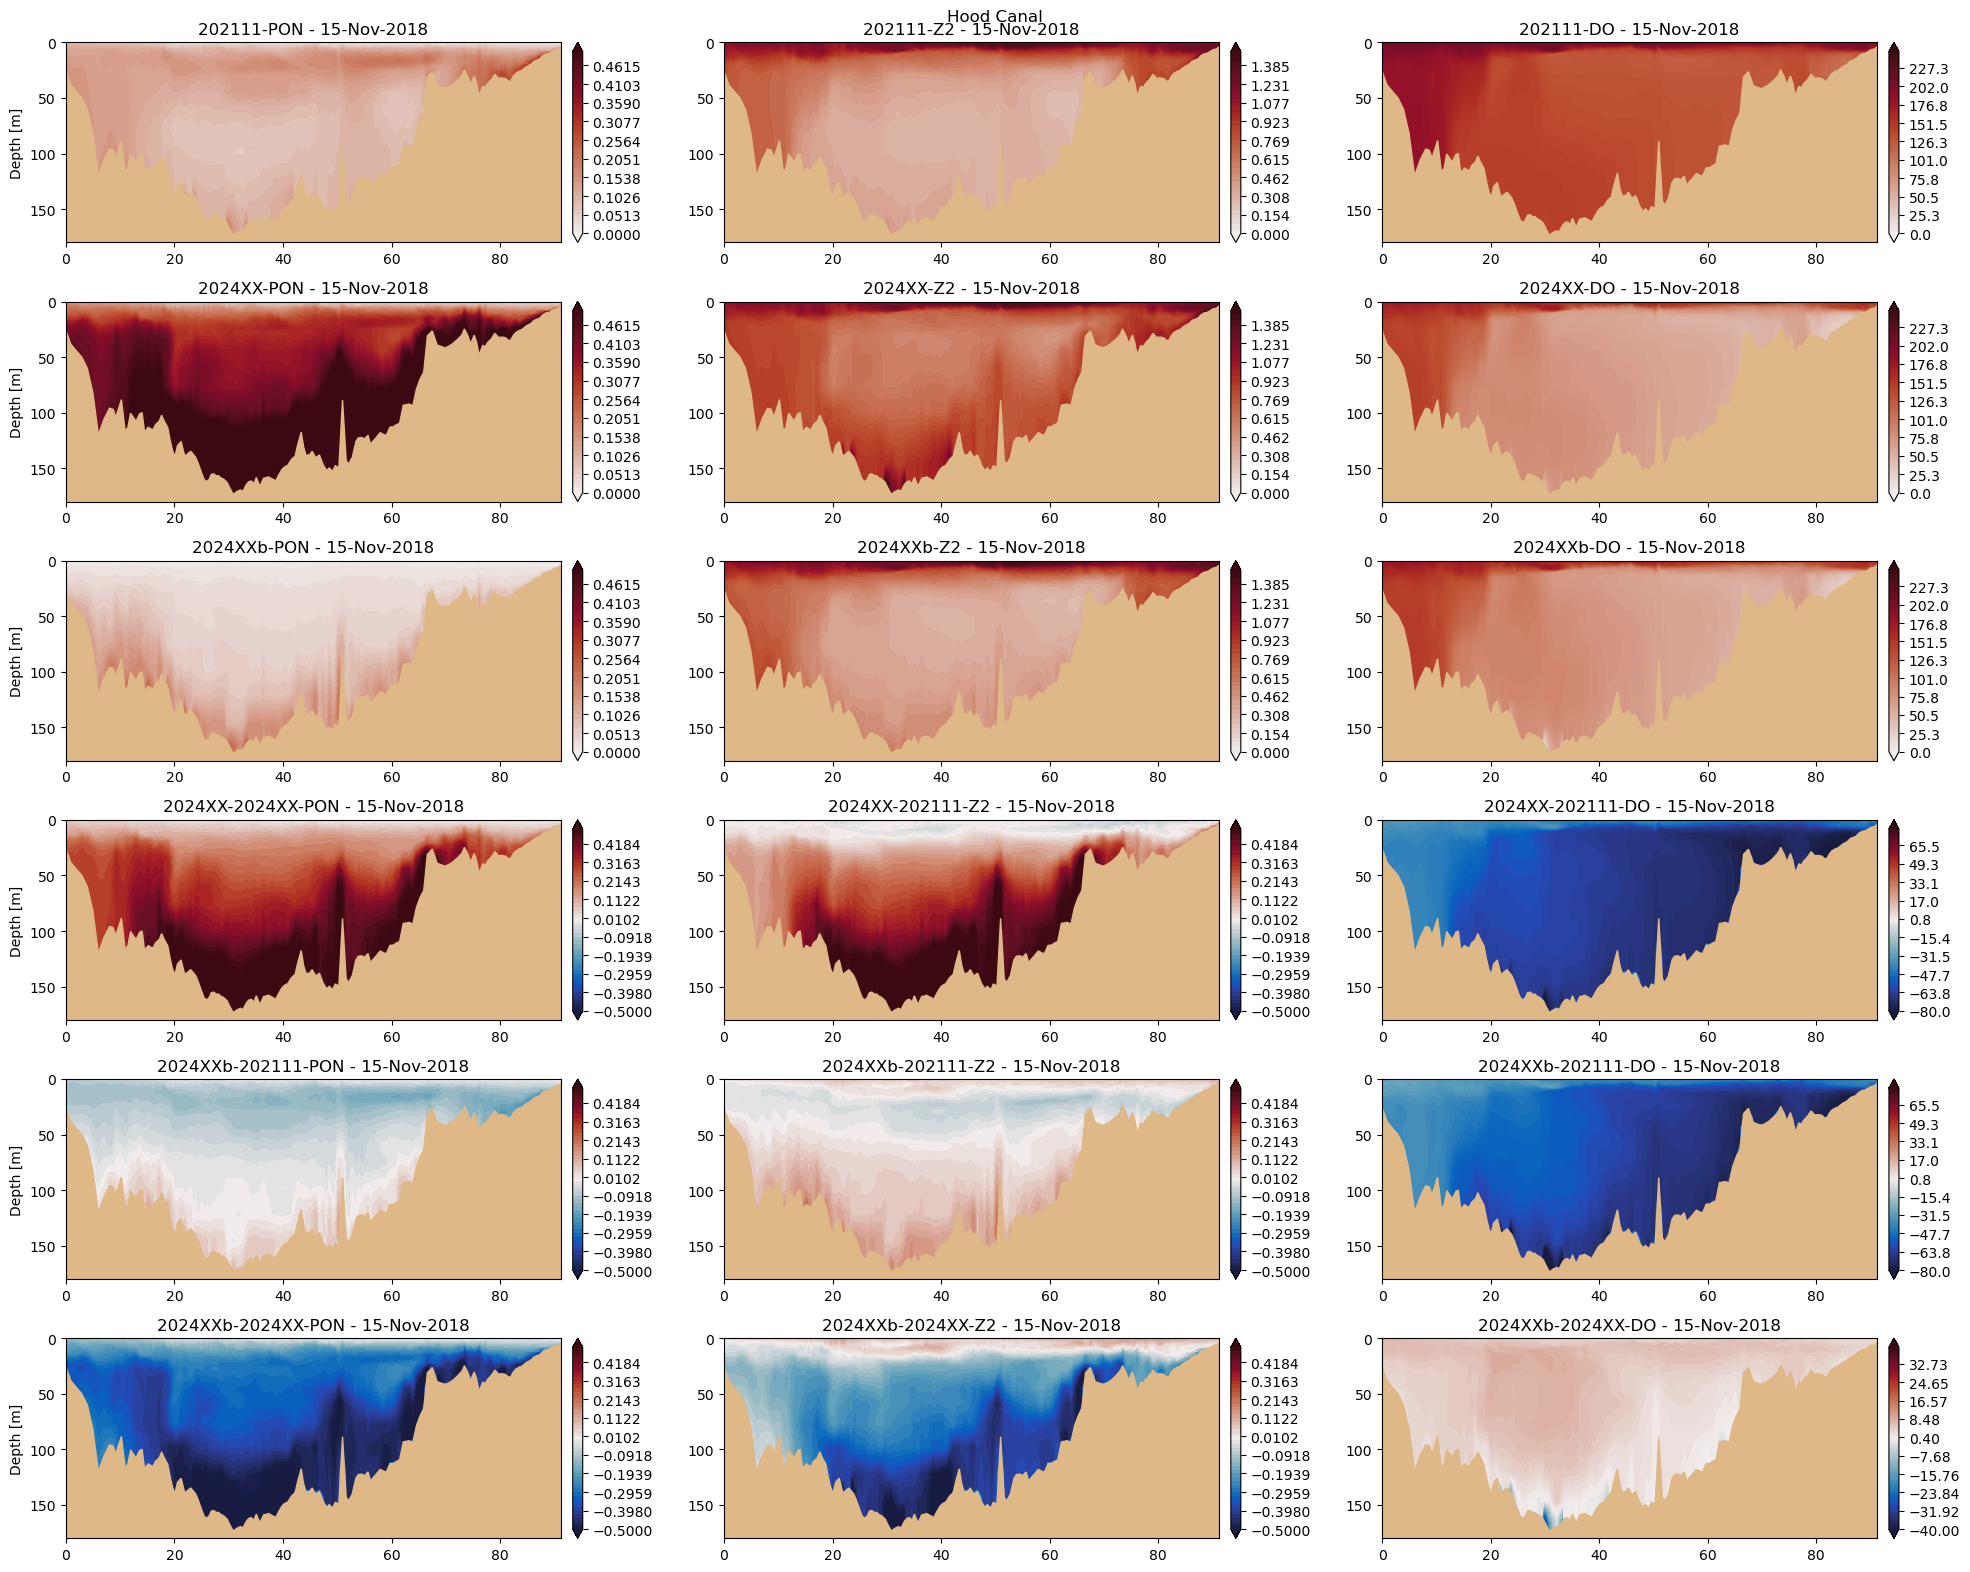

In [39]:
fig, axs = plt.subplots(6, 3, figsize=(20, 16))
lp, cppon, cpmes, cpoxy = 0, 0, 1, 2
Month = list(['14-Nov-2018','15-Nov-2018'])
for month in range(76, 76+1):
    dep_thal, distance, pon_thal = vis.load_thalweg(
                depthb[0, ...], np.array(df_biolold.particulate_organic_nitrogen[month-1]), bathyb['nav_lon'][:], bathyb['nav_lat'][:],
                thalweg_ptsHC)
    dep_thal2, distance2, pon_thal2 = vis.load_thalweg(
                depthb[0, ...], np.array(df_biol.particulate_organic_nitrogen[month-1]), bathyb['nav_lon'][:], bathyb['nav_lat'][:],
                thalweg_ptsHC)
    dep_thal2b, distance2b, pon_thal2b = vis.load_thalweg(
                depthb[0, ...], np.array(df_biolb.particulate_organic_nitrogen[month-1]), bathyb['nav_lon'][:], bathyb['nav_lat'][:],
                thalweg_ptsHC)
    dep_thal, distance, mes_thal = vis.load_thalweg(
                depthb[0, ...], np.array(df_biolold.mesozooplankton[month-1]), bathyb['nav_lon'][:], bathyb['nav_lat'][:],
                thalweg_ptsHC)
    dep_thal2, distance2, mes_thal2 = vis.load_thalweg(
                depthb[0, ...], np.array(df_biol.mesozooplankton[month-1]), bathyb['nav_lon'][:], bathyb['nav_lat'][:],
                thalweg_ptsHC)
    dep_thal2b, distance2b, mes_thal2b = vis.load_thalweg(
                depthb[0, ...], np.array(df_biolb.mesozooplankton[month-1]), bathyb['nav_lon'][:], bathyb['nav_lat'][:],
                thalweg_ptsHC)
    dep_thal, distance, oxy_thal = vis.load_thalweg(
                depthb[0, ...], np.array(df_chemold.dissolved_oxygen[month-1]), bathyb['nav_lon'][:], bathyb['nav_lat'][:],
                thalweg_ptsHC)
    dep_thal2, distance2, oxy_thal2 = vis.load_thalweg(
                depthb[0, ...], np.array(df_chem.dissolved_oxygen[month-1]), bathyb['nav_lon'][:], bathyb['nav_lat'][:],
                thalweg_ptsHC)
    dep_thal2b, distance2b, oxy_thal2b = vis.load_thalweg(
                depthb[0, ...], np.array(df_chemb.dissolved_oxygen[month-1]), bathyb['nav_lon'][:], bathyb['nav_lat'][:],
                thalweg_ptsHC)
    pon_plot = vis._fill_in_bathy(pon_thal, meshb, thalweg_ptsHC)
    mes_plot = vis._fill_in_bathy(mes_thal, meshb, thalweg_ptsHC)
    oxy_plot = vis._fill_in_bathy(oxy_thal, meshb, thalweg_ptsHC)
    pon_plot2 = vis._fill_in_bathy(pon_thal2, meshb, thalweg_ptsHC)
    mes_plot2 = vis._fill_in_bathy(mes_thal2, meshb, thalweg_ptsHC)
    oxy_plot2 = vis._fill_in_bathy(oxy_thal2, meshb, thalweg_ptsHC)
    pon_plot2b = vis._fill_in_bathy(pon_thal2b, meshb, thalweg_ptsHC)
    mes_plot2b = vis._fill_in_bathy(mes_thal2b, meshb, thalweg_ptsHC)
    oxy_plot2b = vis._fill_in_bathy(oxy_thal2b, meshb, thalweg_ptsHC)
    pon_diff = vis._fill_in_bathy(pon_thal2b-pon_thal2, meshb, thalweg_ptsHC)
    mes_diff = vis._fill_in_bathy(mes_thal2b-mes_thal2, meshb, thalweg_ptsHC)
    oxy_diff = vis._fill_in_bathy(oxy_thal2b-oxy_thal2, meshb, thalweg_ptsHC)
    pon_diff2 = vis._fill_in_bathy(pon_thal2-pon_thal, meshb, thalweg_ptsHC)
    mes_diff2 = vis._fill_in_bathy(mes_thal2-mes_thal, meshb, thalweg_ptsHC)
    oxy_diff2 = vis._fill_in_bathy(oxy_thal2-oxy_thal, meshb, thalweg_ptsHC)
    pon_diff2b = vis._fill_in_bathy(pon_thal2b-pon_thal, meshb, thalweg_ptsHC)
    mes_diff2b = vis._fill_in_bathy(mes_thal2b-mes_thal, meshb, thalweg_ptsHC)
    oxy_diff2b = vis._fill_in_bathy(oxy_thal2b-oxy_thal, meshb, thalweg_ptsHC)
    colours_pon = axs[lp,cppon].contourf(distance, dep_thal, pon_plot, np.linspace(0, 0.5, 40), 
                                     cmap=cm.amp, extend='both')
    colours_mes = axs[lp,cpmes].contourf(distance, dep_thal, mes_plot, np.linspace(0, 1.5, 40), 
                                     cmap=cm.amp, extend='both')
    colours_oxy = axs[lp,cpoxy].contourf(distance, dep_thal, oxy_plot, np.linspace(0, 250, 100),                                     
                                    cmap=cm.amp, extend='both') 
    colours_pon2 = axs[lp+1,cppon].contourf(distance2, dep_thal2, pon_plot2, np.linspace(0, 0.5, 40), 
                                     cmap=cm.amp, extend='both')
    colours_mes2 = axs[lp+1,cpmes].contourf(distance2, dep_thal2, mes_plot2, np.linspace(0, 1.5, 40), 
                                     cmap=cm.amp, extend='both')
    colours_oxy2 = axs[lp+1,cpoxy].contourf(distance2, dep_thal2, oxy_plot2, np.linspace(0, 250, 100),                                     
                                    cmap=cm.amp, extend='both')
    colours_pon2b = axs[lp+2,cppon].contourf(distance2b, dep_thal2b, pon_plot2b, np.linspace(0, 0.5, 40), 
                                     cmap=cm.amp, extend='both')
    colours_mes2b = axs[lp+2,cpmes].contourf(distance2b, dep_thal2b, mes_plot2b, np.linspace(0, 1.5, 40), 
                                     cmap=cm.amp, extend='both')
    colours_oxy2b = axs[lp+2,cpoxy].contourf(distance2b, dep_thal2b, oxy_plot2b, np.linspace(0, 250, 100), 
                                             cmap=cm.amp, extend='both')
    colours_pon32 = axs[lp+3,cppon].contourf(distance2, dep_thal2, pon_diff2, np.linspace(-0.5, 0.5, 50), 
                                     cmap=cm.balance, extend='both')
    colours_mes32 = axs[lp+3,cpmes].contourf(distance2, dep_thal2, mes_diff2, np.linspace(-0.5, 0.5, 50), 
                                     cmap=cm.balance, extend='both')
    colours_oxy32 = axs[lp+3,cpoxy].contourf(distance2, dep_thal2, oxy_diff2, np.linspace(-80, 80, 100),                                     
                                    cmap=cm.balance, extend='both')
    colours_pon32b = axs[lp+4,cppon].contourf(distance2, dep_thal2, pon_diff2b, np.linspace(-0.5, 0.5, 50), 
                                     cmap=cm.balance, extend='both')
    colours_mes32b = axs[lp+4,cpmes].contourf(distance2, dep_thal2, mes_diff2b, np.linspace(-0.5, 0.5, 50), 
                                     cmap=cm.balance, extend='both')
    colours_oxy32b = axs[lp+4,cpoxy].contourf(distance2b, dep_thal2b, oxy_diff2b, np.linspace(-80, 80, 100),                                     
                                    cmap=cm.balance, extend='both')
    colours_pon3 = axs[lp+5,cppon].contourf(distance2, dep_thal2, pon_diff, np.linspace(-0.5, 0.5, 50), 
                                     cmap=cm.balance, extend='both')
    colours_mes3 = axs[lp+5,cpmes].contourf(distance2, dep_thal2, mes_diff, np.linspace(-0.5, 0.5, 50), 
                                     cmap=cm.balance, extend='both')
    colours_oxy3 = axs[lp+5,cpoxy].contourf(distance2, dep_thal2, oxy_diff, np.linspace(-40, 40, 100),                                     
                                    cmap=cm.balance, extend='both')
    vis._add_bathy_patch(
    distance, bathyb['Bathymetry'][:], thalweg_ptsHC, axs[lp,cppon], color='burlywood')
    vis._add_bathy_patch(
    distance, bathyb['Bathymetry'][:], thalweg_ptsHC, axs[lp,cpmes], color='burlywood')
    vis._add_bathy_patch(
    distance, bathyb['Bathymetry'][:], thalweg_ptsHC, axs[lp,cpoxy], color='burlywood')
    vis._add_bathy_patch(
    distance2, bathyb['Bathymetry'][:], thalweg_ptsHC, axs[lp+1,cppon], color='burlywood')
    vis._add_bathy_patch(
    distance2, bathyb['Bathymetry'][:], thalweg_ptsHC, axs[lp+1,cpmes], color='burlywood')
    vis._add_bathy_patch(
    distance2, bathyb['Bathymetry'][:], thalweg_ptsHC, axs[lp+1,cpoxy], color='burlywood')
    vis._add_bathy_patch(
    distance2b, bathyb['Bathymetry'][:], thalweg_ptsHC, axs[lp+2,cppon], color='burlywood')
    vis._add_bathy_patch(
    distance2b, bathyb['Bathymetry'][:], thalweg_ptsHC, axs[lp+2,cpmes], color='burlywood')
    vis._add_bathy_patch(
    distance2b, bathyb['Bathymetry'][:], thalweg_ptsHC, axs[lp+2,cpoxy], color='burlywood')
    vis._add_bathy_patch(
    distance2, bathyb['Bathymetry'][:], thalweg_ptsHC, axs[lp+3,cppon], color='burlywood')
    vis._add_bathy_patch(
    distance2, bathyb['Bathymetry'][:], thalweg_ptsHC, axs[lp+3,cpmes], color='burlywood')
    vis._add_bathy_patch(
    distance2, bathyb['Bathymetry'][:], thalweg_ptsHC, axs[lp+3,cpoxy], color='burlywood')
    vis._add_bathy_patch(
    distance2, bathyb['Bathymetry'][:], thalweg_ptsHC, axs[lp+4,cppon], color='burlywood')
    vis._add_bathy_patch(
    distance2, bathyb['Bathymetry'][:], thalweg_ptsHC, axs[lp+4,cpmes], color='burlywood')
    vis._add_bathy_patch(
    distance2, bathyb['Bathymetry'][:], thalweg_ptsHC, axs[lp+4,cpoxy], color='burlywood')
    vis._add_bathy_patch(
    distance2, bathyb['Bathymetry'][:], thalweg_ptsHC, axs[lp+5,cppon], color='burlywood')
    vis._add_bathy_patch(
    distance2, bathyb['Bathymetry'][:], thalweg_ptsHC, axs[lp+5,cpmes], color='burlywood')
    vis._add_bathy_patch(
    distance2, bathyb['Bathymetry'][:], thalweg_ptsHC, axs[lp+5,cpoxy], color='burlywood')
    axs[lp,cppon].invert_yaxis()
    axs[lp,cpmes].invert_yaxis()
    axs[lp,cpoxy].invert_yaxis()
    axs[lp+1,cppon].invert_yaxis()
    axs[lp+1,cpmes].invert_yaxis()
    axs[lp+1,cpoxy].invert_yaxis()
    axs[lp,cppon].set_ylim(180, 0)
    axs[lp,cpmes].set_ylim(180, 0)
    axs[lp,cpoxy].set_ylim(180, 0)
    axs[lp+1,cppon].set_ylim(180, 0)
    axs[lp+1,cpmes].set_ylim(180, 0)
    axs[lp+1,cpoxy].set_ylim(180, 0)
    axs[lp+2,cppon].set_ylim(180, 0)
    axs[lp+2,cpmes].set_ylim(180, 0)
    axs[lp+2,cpoxy].set_ylim(180, 0)
    axs[lp+3,cppon].set_ylim(180, 0)
    axs[lp+3,cpmes].set_ylim(180, 0)
    axs[lp+3,cpoxy].set_ylim(180, 0)
    axs[lp+4,cppon].set_ylim(180, 0)
    axs[lp+4,cpmes].set_ylim(180, 0)
    axs[lp+4,cpoxy].set_ylim(180, 0)
    axs[lp+5,cppon].set_ylim(180, 0)
    axs[lp+5,cpmes].set_ylim(180, 0)
    axs[lp+5,cpoxy].set_ylim(180, 0)
    axs[lp,cppon].set_ylabel('Depth [m]');
    axs[lp+1,cppon].set_ylabel('Depth [m]');
    axs[lp+2,cppon].set_ylabel('Depth [m]');
    axs[lp+3,cppon].set_ylabel('Depth [m]');
    axs[lp+4,cppon].set_ylabel('Depth [m]');
    axs[lp+5,cppon].set_ylabel('Depth [m]');
    axs[lp,cppon].set_title(f'202111-PON - {Month[month-75]}')
    axs[lp,cpmes].set_title(f'202111-Z2 - {Month[month-75]}')
    axs[lp,cpoxy].set_title(f'202111-DO - {Month[month-75]}')
    axs[lp+1,cppon].set_title(f'2024XX-PON - {Month[month-75]}')
    axs[lp+1,cpmes].set_title(f'2024XX-Z2 - {Month[month-75]}')
    axs[lp+1,cpoxy].set_title(f'2024XX-DO - {Month[month-75]}')
    axs[lp+2,cppon].set_title(f'2024XXb-PON - {Month[month-75]}')
    axs[lp+2,cpmes].set_title(f'2024XXb-Z2 - {Month[month-75]}')
    axs[lp+2,cpoxy].set_title(f'2024XXb-DO - {Month[month-75]}')
    axs[lp+3,cppon].set_title(f'2024XX-2024XX-PON - {Month[month-75]}')
    axs[lp+3,cpmes].set_title(f'2024XX-202111-Z2 - {Month[month-75]}')
    axs[lp+3,cpoxy].set_title(f'2024XX-202111-DO - {Month[month-75]}')
    axs[lp+4,cppon].set_title(f'2024XXb-202111-PON - {Month[month-75]}')
    axs[lp+4,cpmes].set_title(f'2024XXb-202111-Z2 - {Month[month-75]}')
    axs[lp+4,cpoxy].set_title(f'2024XXb-202111-DO - {Month[month-75]}')
    axs[lp+5,cppon].set_title(f'2024XXb-2024XX-PON - {Month[month-75]}')
    axs[lp+5,cpmes].set_title(f'2024XXb-2024XX-Z2 - {Month[month-75]}')
    axs[lp+5,cpoxy].set_title(f'2024XXb-2024XX-DO - {Month[month-75]}')
    cbar = fig.colorbar(colours_pon, ax=axs[lp,cppon], pad=0.02)
    cbar = fig.colorbar(colours_mes, ax=axs[lp,cpmes], pad=0.02)
    cbar = fig.colorbar(colours_oxy, ax=axs[lp,cpoxy], pad=0.02)
    cbar = fig.colorbar(colours_pon2, ax=axs[lp+1,cppon], pad=0.02)
    cbar = fig.colorbar(colours_mes2, ax=axs[lp+1,cpmes], pad=0.02)
    cbar = fig.colorbar(colours_oxy2, ax=axs[lp+1,cpoxy], pad=0.02)
    cbar = fig.colorbar(colours_pon2b, ax=axs[lp+2,cppon], pad=0.02)
    cbar = fig.colorbar(colours_mes2b, ax=axs[lp+2,cpmes], pad=0.02)
    cbar = fig.colorbar(colours_oxy2b, ax=axs[lp+2,cpoxy], pad=0.02)
    cbar = fig.colorbar(colours_pon32, ax=axs[lp+3,cppon], pad=0.02)
    cbar = fig.colorbar(colours_mes32, ax=axs[lp+3,cpmes], pad=0.02)
    cbar = fig.colorbar(colours_oxy32, ax=axs[lp+3,cpoxy], pad=0.02)
    cbar = fig.colorbar(colours_pon32b, ax=axs[lp+4,cppon], pad=0.02)
    cbar = fig.colorbar(colours_mes32b, ax=axs[lp+4,cpmes], pad=0.02)
    cbar = fig.colorbar(colours_oxy32b, ax=axs[lp+4,cpoxy], pad=0.02)
    cbar = fig.colorbar(colours_pon3, ax=axs[lp+5,cppon], pad=0.02)
    cbar = fig.colorbar(colours_mes3, ax=axs[lp+5,cpmes], pad=0.02)
    cbar = fig.colorbar(colours_oxy3, ax=axs[lp+5,cpoxy], pad=0.02)
#    lp = lp + 1;
fig.suptitle('Hood Canal');
fig.tight_layout();